# <div align = "center" style="color:rgb(250, 250, 20);"> lat_cust_info </div>

# Define Libraries

In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.
# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\Dwaipayan\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')


from datetime import datetime

# %% [markdown]
## Configure Settings
# Set options or configurations as needed

# Example: pd.set_option('display.max_columns', None)



### SQL Query Logic Documentation: Customer Loan Journey Analysis

This query constructs a comprehensive customer profile by analyzing loan application behavior across multiple stages. Below is a detailed breakdown of the logic:

---

#### **1. Base Customer Data (`cust_base`)**  
```sql
with cust_base as (
  select * 
  from `dl_customers_db_raw.tdbk_customer_mtb`
  where cust_id is not null
)
```
- **Purpose**: Filters valid customers from the core customer table.
- **Logic**:
  - Selects all customers with non-null `cust_id`.
  - Commented filters (`status`, `created_dt`) are inactive but indicate potential future use cases.
- **Output**: Foundational customer dataset.

---

#### **2. First Loan Applications (`first_loan_application`)**  
```sql
first_loan_application as (
  select 
    custId,
    digitalLoanAccountId,
    loanaccountnumber,
    isTermsAndConditionstimestamp,
    poi1RejectType,
    loantype 
  from `dl_loans_db_raw.tdbk_digital_loan_application`
)
```
- **Purpose**: Identifies key attributes of customers' first loan applications.
- **Logic**:
  - Pulls loan application data without filtering (commented deduplication logic is inactive).
  - Critical fields: `custId`, loan identifiers, T&C acceptance timestamp, rejection reason, and loan type.
- **Why?**: Serves as the anchor point for loan journey analysis.

---

#### **3. Loan Calculator Engagement (`loan_calculator`)**  
```sql
loan_calculator as (
  select custid, digitalLoanAccountId
  from (
    SELECT 
      fla.custid,
      fla.digitalLoanAccountId,
      SUM(CASE WHEN a.applicationStatus='INITIATE' THEN 1 ELSE 0 END) loan_calculator
    FROM `dl_loans_db_raw.tdbk_status_trace` a
    JOIN first_loan_application fla
      ON fla.digitalLoanAccountId = a.digitalLoanAccountId
    GROUP BY 1,2
  )
  where loan_calculator > 0
)
```
- **Purpose**: Flags customers who initiated a loan calculator session.
- **Logic**:
  - Joins loan applications with status traces to detect `INITIATE` events.
  - Counts `INITIATE` statuses per loan application.
  - Filters for applications with ≥1 calculator session (`loan_calculator > 0`).
- **Output**: `custid` and loan IDs where calculator was used.

---

#### **4. Approved Loans (`disbursed_undisbursed_loan`)**  
```sql
disbursed_undisbursed_loan as (
  SELECT 
    fla.custid,
    fla.digitalLoanAccountId
  FROM `dl_loans_db_raw.tdbk_status_trace` a
  JOIN first_loan_application fla
    ON fla.digitalLoanAccountId = a.digitalLoanApplicationId
  WHERE a.applicationStatus = 'APPROVED'
  GROUP BY 1,2
)
```
- **Purpose**: Identifies loans approved via scorecard.
- **Logic**:
  - Filters status traces for `APPROVED` status.
  - Groups by customer and loan ID to deduplicate records.
- **Note**: Does not imply disbursement (only approval).

---

#### **5. Consolidated Customer Profile (`cust_info`)**  
```sql
cust_info as (
  select 
    cb.*,
    fla.digitalLoanAccountId,
    fla.loantype,
    CASE WHEN lc.custid IS NOT NULL THEN 1 ELSE 0 END AS flg_loan_calculator,
    CASE WHEN fla.poi1RejectType IS NOT NULL OR fla.loantype IS NULL THEN 1 ELSE 0 END AS flg_reject_rule_check,
    CASE WHEN (fla.isTermsAndConditionstimestamp IS NOT NULL OR loan.new_loan_type ='Flex-up') THEN 1 ELSE 0 END AS flg_applied_loan,
    CASE WHEN ul.custid IS NOT NULL THEN 1 ELSE 0 END AS flg_approved_scorecard_loan,
    CASE WHEN fla.loanaccountnumber IS NOT NULL THEN 1 ELSE 0 END AS flg_disbursed_loan,
    fla.loanaccountnumber AS loan_id
  from cust_base cb
  LEFT JOIN first_loan_application fla
    ON CAST(cb.cust_id AS INT64) = fla.custId
  LEFT JOIN loan_calculator lc
    ON lc.digitalLoanAccountId = fla.digitalLoanAccountId
  LEFT JOIN disbursed_undisbursed_loan ul
    ON ul.digitalLoanAccountId = fla.digitalLoanAccountId
  LEFT JOIN risk_credit_mis.loan_master_table loan 
    ON loan.digitalLoanAccountId = fla.digitalLoanAccountId
)
```
- **Purpose**: Creates master customer profile with loan journey flags.
- **Key Flags**:
  1. **`flg_loan_calculator`**: Used loan calculator (0/1).
  2. **`flg_reject_rule_check`**: Rejected by rules or missing loan type (0/1).
  3. **`flg_applied_loan`**: Completed application (T&C accepted or Flex-up loan).
  4. **`flg_approved_scorecard_loan`**: Approved by underwriting (0/1).
  5. **`flg_disbursed_loan`**: Loan disbursed (0/1, based on `loanaccountnumber`).
- **Joins Logic**:
  - Starts with `cust_base` → left-joins to loan applications to ensure all customers are retained.
  - Links to calculator, approval, and disbursement data via `digitalLoanAccountId`.
  - Includes `loan_master_table` for loan type validation (e.g., Flex-up).

---

#### **6. Final Output**  
```sql
select * from cust_info;
```
- Returns all customer profiles with loan journey flags.

---

### **Key Insights & Notes**
1. **Customer Coverage**:
   - Includes **all valid customers** (`cust_id NOT NULL`), regardless of loan activity.
   - Non-applicants will have `NULL` values for loan-related fields.

2. **Journey Progression**:
   - Flags represent funnel stages:  
     `calculator → application → approval → disbursement`
   - A customer may skip stages (e.g., apply without using calculator).

3. **Critical Business Rules**:
   - **Rejection Flag**: Triggered if `poi1RejectType` exists (explicit rejection) or `loantype` is missing (data issue).
   - **Application Flag**: Accepts T&C timestamp OR Flex-up loan type (special case).
   - **Disbursement**: Inferred from presence of `loanaccountnumber`.

4. **Performance Note**:
   - Avoids costly operations (e.g., deduplication in `first_loan_application` is commented out).
   - Aggregations (`loan_calculator`, `disbursed_undisbursed_loan`) minimize row counts early.

5. **Improvement Opportunities**:
   - Uncomment `status`/`created_dt` filters in `cust_base` for specific cohorts.
   - Add deduplication logic for `first_loan_application` if needed.

---

### **Data Flow Diagram**
```mermaid
flowchart TD
  A[cust_base] -->|cust_id| D[cust_info]
  B[first_loan_application] -->|digitalLoanAccountId| C[loan_calculator]
  B -->|digitalLoanAccountId| E[disbursed_undisbursed_loan]
  C --> D
  E --> D
  B -->|custId| D
  F[loan_master_table] -->|digitalLoanAccountId| D
```

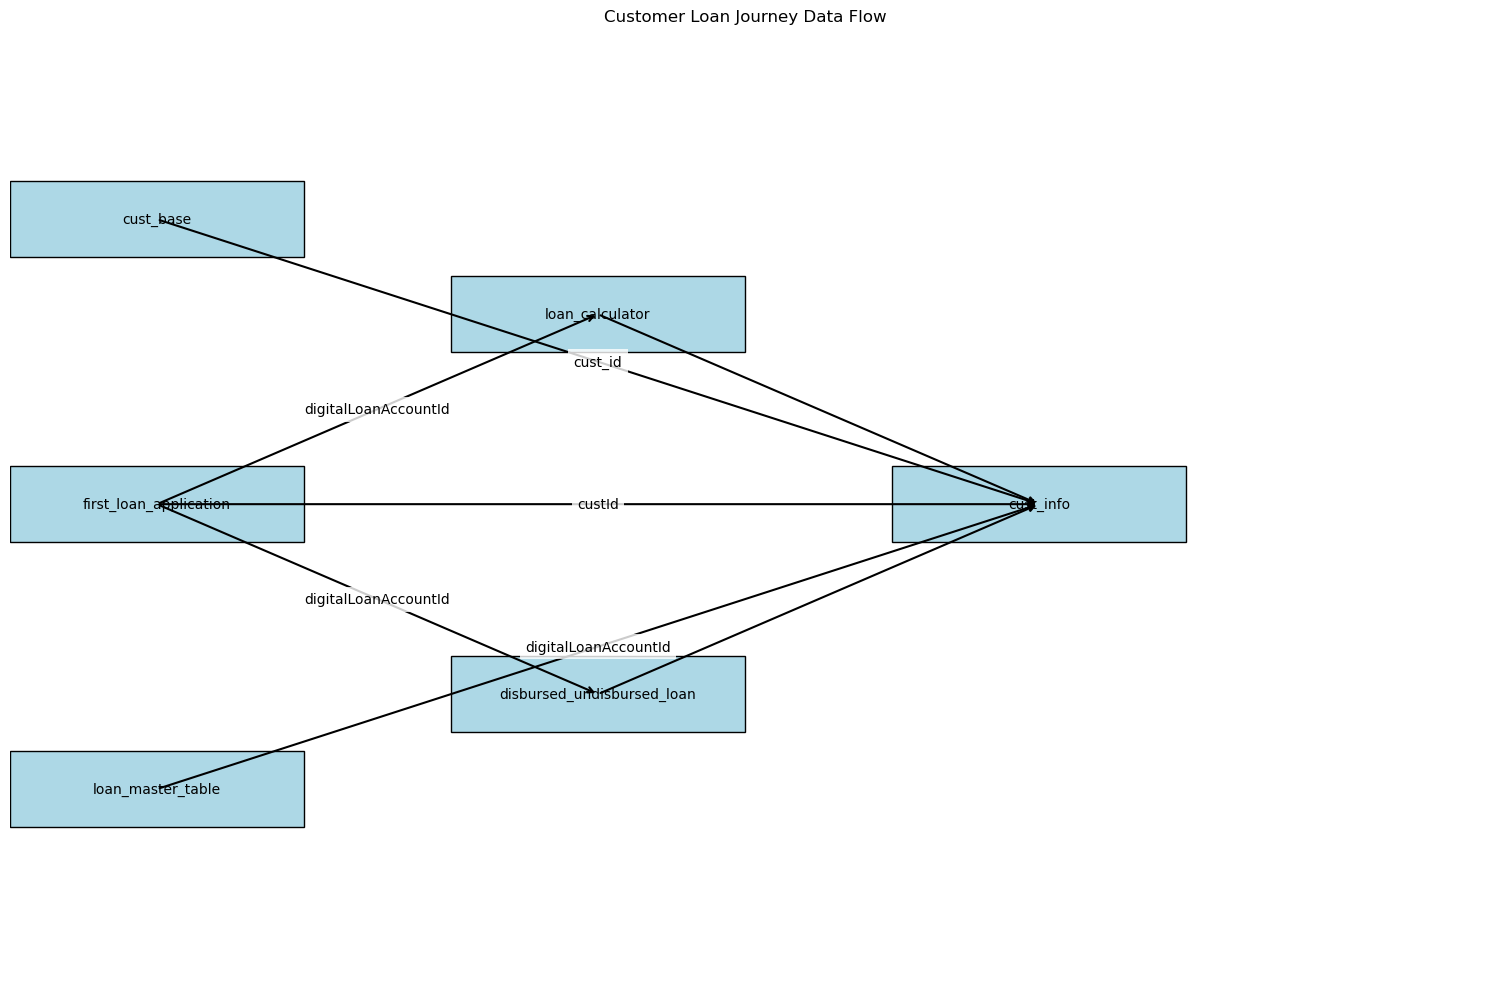

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.lines as lines

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Node positions (x, y)
nodes = {
    'A': (1, 8, 'cust_base'),
    'B': (1, 5, 'first_loan_application'),
    'C': (4, 7, 'loan_calculator'),
    'D': (7, 5, 'cust_info'),
    'E': (4, 3, 'disbursed_undisbursed_loan'),
    'F': (1, 2, 'loan_master_table')
}

# Draw nodes
for key, (x, y, label) in nodes.items():
    ax.add_patch(patches.Rectangle((x-1, y-0.4), 2, 0.8, 
                  facecolor='lightblue', edgecolor='black'))
    ax.text(x, y, label, ha='center', va='center', fontsize=10)

# Draw connections
connections = [
    ('A', 'D', 'cust_id'),
    ('B', 'C', 'digitalLoanAccountId'),
    ('B', 'E', 'digitalLoanAccountId'),
    ('C', 'D', ''),
    ('E', 'D', ''),
    ('B', 'D', 'custId'),
    ('F', 'D', 'digitalLoanAccountId')
]

for start, end, label in connections:
    x1, y1, _ = nodes[start]
    x2, y2, _ = nodes[end]
    
    # Draw arrow
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=1.5))
    
    # Draw label
    if label:
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        ax.text(mid_x, mid_y, label, 
                ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.title('Customer Loan Journey Data Flow')
plt.tight_layout()
plt.show()

## Query

In [2]:
query = """ 
Create or replace table `dap_ds_poweruser_playground.lat_cust_info` as 
with cust_base as(
select * from `dl_customers_db_raw.tdbk_customer_mtb`
where cust_id is not null
--and status in ('C','A')
--and date(created_dt,'Asia/Manila') >= '2021-07-01'
),
first_loan_application as (
select custId,digitalLoanAccountId,loanaccountnumber,isTermsAndConditionstimestamp,poi1RejectType,loantype from
--(select * from 
`dl_loans_db_raw.tdbk_digital_loan_application`
--where custId in (select cast(cust_id as integer) from cust_base) qualify row_number() over (partition by custId order by created_dt) = 1)
--where --loanType in ('TUL') and coalesce(flowType,'1') <> '2'
),
loan_calculator as (
select custid,digitalLoanAccountId from
(SELECT fla.custid,fla.digitalLoanAccountId,
sum(case when a.applicationStatus='INITIATE' then 1 else 0 end) loan_calculator
 FROM `dl_loans_db_raw.tdbk_status_trace`  a
 join first_loan_application fla
 on fla.digitalLoanAccountId=a.digitalLoanAccountId
 group by 1,2)
where loan_calculator>0
),
disbursed_undisbursed_loan as (
SELECT fla.custid,fla.digitalLoanAccountId,
 FROM `dl_loans_db_raw.tdbk_status_trace`  a
 join first_loan_application fla
 on fla.digitalLoanAccountId=a.digitalLoanAccountId
 where a.applicationStatus ='APPROVED'
 group by 1,2
)
,
cust_info as 
(select 
 cb.*, fla.digitalLoanAccountId,--onboarding_datetime, 
 fla.loantype,
case when lc.custid is not null then 1 else 0 end as flg_loan_calculator,
case when fla.poi1RejectType is not null or fla.loantype is null then 1 else 0 end as flg_reject_rule_check,
case when (fla.isTermsAndConditionstimestamp is not null or loan.new_loan_type ='Flex-up')  then 1 else 0 end as flg_applied_loan,
case when ul.custid is not null then 1 else 0 end as flg_approved_scorecard_loan,
case when fla.loanaccountnumber is not null then 1 else 0 end as flg_disbursed_loan,
fla.loanaccountnumber as loan_id
from cust_base cb
left join first_loan_application fla
on cast(cb.cust_id as integer)=fla.custId
left join loan_calculator lc
--on cast(cb.cust_id as integer)=lc.custid and 
on lc.digitalLoanAccountId=fla.digitalLoanAccountId
left join disbursed_undisbursed_loan ul
--on cast(cb.cust_id as integer)=ul.custid)
on ul.digitalLoanAccountId=fla.digitalLoanAccountId
left join 
risk_credit_mis.loan_master_table loan on loan.digitalLoanAccountId=fla.digitalLoanAccountId)
select * from cust_info;
"""
query_job = client.query(query)
# Wait for the job to complete.
query_job.result()
print(f"Created table: {query_job.destination}")

Created table: prj-prod-dataplatform.dap_ds_poweruser_playground.lat_cust_info
